# Daily Tweets Monitoring
## Index:
1. Download of data
2. Data preparation
3. EDA
4. WordCloud
5. Sentiment Analysis
6. LDA Clustering
7. Distribution of tweets


In [1]:
import pandas as pd
import time
import tweepy
from tqdm import tqdm, notebook
import seaborn as sns
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from iso3166 import countries
import plotly.express as plotex
import re
from nltk.tokenize import TweetTokenizer
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
import itertools
import collections
from shifterator import symmetric_shift as ss

## 1. Download of data 

In [2]:
auth = tweepy.OAuthHandler('API_KEY', 'API_SECRET')
api = tweepy.API(auth, wait_on_rate_limit=True)

In [3]:
start_date = '2020-12-04'
search_words = '#covid19 -filter:retweets'
tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en",
              since=start_date).items(10000)

In [ ]:
tweets_retrieve = []
for tweet in tqdm(tweets):
     tweets_retrieve.append(tweet)

6575it [02:40, 47.69it/s]

## 2. Data preparation:

In [ ]:
df = pd.DataFrame()
for tweet in tqdm(tweets_retrieve):
    hashtags = []
    try:
        for hashtag in tweet.entities["hashtags"]:
            hashtags.append(hashtag["text"])
        text = api.get_status(id=tweet.id, tweet_mode='extended').full_text
    except:
        pass
    
    df = tweets_df.append(pd.DataFrame({'user_name': tweet.user.name, 
                                        'user_location': tweet.user.location,\
                                        'user_description': tweet.user.description,
                                        'user_created': tweet.user.created_at,
                                        'user_followers': tweet.user.followers_count,
                                        'user_friends': tweet.user.friends_count,
                                        'user_favourites': tweet.user.favourites_count,
                                        'user_verified': tweet.user.verified,
                                        'date': tweet.created_at,
                                        'text': text, 
                                        'hashtags': [hashtags if hashtags else None],
                                        'source': tweet.source,
                                        'is_retweet': tweet.retweeted}, index=[0]))

In [ ]:
df.to_csv('covid_tweets_10000.csv')

## 3. EDA:

In [3]:
df = pd.read_csv('covid_tweets_10000.csv', index_col=0)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,"Diana ""Sunshine"" Wulf","Nebraska, USA,",SHOW ME WHAT YOU GOT! ☀️🌖✨,2009-05-23 02:16:48,3489,608,29618,False,2020-12-04 13:13:30,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['COVID19'],Twitter Web App,False
0,Kanishka,Ranchi,Bicycle Mayor of Ranchi | Author - You & Me | ...,2009-06-27 11:53:29,1583,385,1858,False,2020-12-04 13:13:25,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['CoVID19'],Twitter for Android,False
0,Amesh Adalja,"Pittsburgh, Baltimore, NYC",Infectious disease MD (also CCM and EM)working...,2010-12-16 20:41:15,34992,2026,2490,True,2020-12-04 13:13:20,In this piece I’m quoted about the mind-boggli...,NaN,Twitter for iPhone,False
0,Dimitri Lascaris,"Montréal, Québec","Lawyer, journalist, activist and eco-socialist...",2010-11-12 01:32:04,7765,728,9344,False,2020-12-04 13:13:15,"Over a recent four-week period, the 20 Toronto...",NaN,Twitter for iPhone,False
0,sebszczepaniak,"Blonay, Suisse",Cycling enthusiast & Old school football fan.,2011-07-20 15:26:14,127,499,74,False,2020-12-04 13:13:15,A must see #diet #meat #health #COVID19 https:...,"['diet', 'meat', 'health', 'COVID19']",Twitter for iPhone,False


In [4]:
df.reset_index(inplace=True, drop=True)

In [8]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,"Diana ""Sunshine"" Wulf","Nebraska, USA,",SHOW ME WHAT YOU GOT! ☀️🌖✨,2009-05-23 02:16:48,3489,608,29618,False,2020-12-04 13:13:30,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['COVID19'],Twitter Web App,False
1,Kanishka,Ranchi,Bicycle Mayor of Ranchi | Author - You & Me | ...,2009-06-27 11:53:29,1583,385,1858,False,2020-12-04 13:13:25,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['CoVID19'],Twitter for Android,False
2,Amesh Adalja,"Pittsburgh, Baltimore, NYC",Infectious disease MD (also CCM and EM)working...,2010-12-16 20:41:15,34992,2026,2490,True,2020-12-04 13:13:20,In this piece I’m quoted about the mind-boggli...,NaN,Twitter for iPhone,False
3,Dimitri Lascaris,"Montréal, Québec","Lawyer, journalist, activist and eco-socialist...",2010-11-12 01:32:04,7765,728,9344,False,2020-12-04 13:13:15,"Over a recent four-week period, the 20 Toronto...",NaN,Twitter for iPhone,False
4,sebszczepaniak,"Blonay, Suisse",Cycling enthusiast & Old school football fan.,2011-07-20 15:26:14,127,499,74,False,2020-12-04 13:13:15,A must see #diet #meat #health #COVID19 https:...,"['diet', 'meat', 'health', 'COVID19']",Twitter for iPhone,False


In [5]:
df.tail()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
9995,Nelson J. Otwoma,"Nairobi, Kenya","Based @NEPHAKKENYA, member, @gnpplus @wofakken...",2013-11-05 03:50:11,3470,3683,573,False,2020-12-04 06:09:11,6 days to #UHCDay #Bain of @Alfajiri is asking...,"['UHCDay', 'Bain', 'UHC']",Twitter for Android,False
9996,Burn-Out sous Toutenmakhron,NaN,RT ne veut pas dire soutien,2017-10-08 05:27:23,127,19,11342,False,2020-12-04 06:09:10,@black_to_fade @Psydonix @AnonDCC Check out Fa...,NaN,Twitter for Android,False
9997,AIR News Ranchi (#WearAMask #SaveLives),"Ranchi, India",Official Twitter account of Regional News Unit...,2017-03-24 10:08:36,2937,149,553,False,2020-12-04 06:09:08,#CoronaVirusUpdates:\n\n#COVID19 India Tracker...,"['CoronaVirusUpdates', 'COVID19']",Twitter Web App,False
9998,Ian Lyne,NaN,You Tube: https://t.co/p7ORCcGdm1\nArchive of ...,2020-11-10 06:49:19,2963,2391,4241,False,2020-12-04 06:09:08,@NeilClark66 \n@ClarkeMicah \n\nEXPLOSIVE! \n\...,NaN,Twitter Web App,False
9999,News Daily 24,"Guwahati, Assam",ND24 is a bilingual news web portal headquarte...,2020-03-15 09:50:14,590,178,4,False,2020-12-04 06:09:07,India’s active Caseload further dips to 4.35% ...,NaN,Twitter Web App,False


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user_name         10000 non-null  object
 1   user_location     7933 non-null   object
 2   user_description  9382 non-null   object
 3   user_created      10000 non-null  object
 4   user_followers    10000 non-null  int64 
 5   user_friends      10000 non-null  int64 
 6   user_favourites   10000 non-null  int64 
 7   user_verified     10000 non-null  bool  
 8   date              10000 non-null  object
 9   text              10000 non-null  object
 10  hashtags          6984 non-null   object
 11  source            9985 non-null   object
 12  is_retweet        10000 non-null  bool  
dtypes: bool(2), int64(3), object(8)
memory usage: 879.0+ KB


In [5]:
## date to date-time format:
df['date'] = pd.to_datetime(df.date)
print(df.date.dtype)

datetime64[ns]


In [8]:
df['date'].iloc[0]

Timestamp('2020-12-04 13:13:30')

In [6]:

df['tweet_time'] = df.date.astype(str).str.split(expand=True)[1]

In [10]:
df.user_location.unique()

array(['Nebraska, USA,', 'Ranchi', 'Pittsburgh, Baltimore, NYC', ...,
       'Nagpur, Maharashtra, India', 'Bochum, Germany', 'Ottawa, Canada'],
      dtype=object)

In [11]:
len(df.user_location.unique())

3063

In [12]:
df.hashtags.unique()

array(["['COVID19']", "['CoVID19']", nan, ...,
       "['COVID19', 'Coronaviruspakistan']",
       "['Animals', 'BorisJohnson', 'Comedy', 'Covid19', 'Cure', 'Film', 'Indie', 'Meme', 'UK', 'Video', 'WebSeries']",
       "['UHCDay', 'Bain', 'UHC']"], dtype=object)

In [13]:
len(df.hashtags.unique())

3629

In [14]:
df.hashtags.value_counts()

['COVID19']                                                                                           1934
['Covid19']                                                                                            235
['covid19']                                                                                            112
['coronavirus', 'CoronaVirusUpdate', 'COVID19', 'CoronavirusPandemic']                                  54
['pmrdungun', 'japentrg', 'pkpp', 'tidakpastijangankongsi', 'kitajagakita', 'kitateguhkitamenang']      45
                                                                                                      ... 
['crowddfunding', 'gymnastics', 'ventilation', 'COVID19']                                                1
['Cainiao']                                                                                              1
['covid19', 'japan', 'virus']                                                                            1
['Biden', 'COVID19', 'fridaymorning']

In [15]:
hashtags_count_series = df.hashtags.value_counts()
print('Number of unique groups of hashtags',len(hashtags_count_series))
print('Number repeated groups of hashtags',len(hashtags_count_series[hashtags_count_series > 1]))

Number of unique groups of hashtags 3628
Number repeated groups of hashtags 397


In [16]:
df.date.min()

Timestamp('2020-12-04 06:09:07')

In [17]:
df.date.min()

Timestamp('2020-12-04 06:09:07')

/Users/germanpinzon/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/germanpinzon/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/germanpinzon/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10024 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/germanpinzon/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/germanpinzon/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/germanpinzon/anaconda3/lib/python3.7/site-p

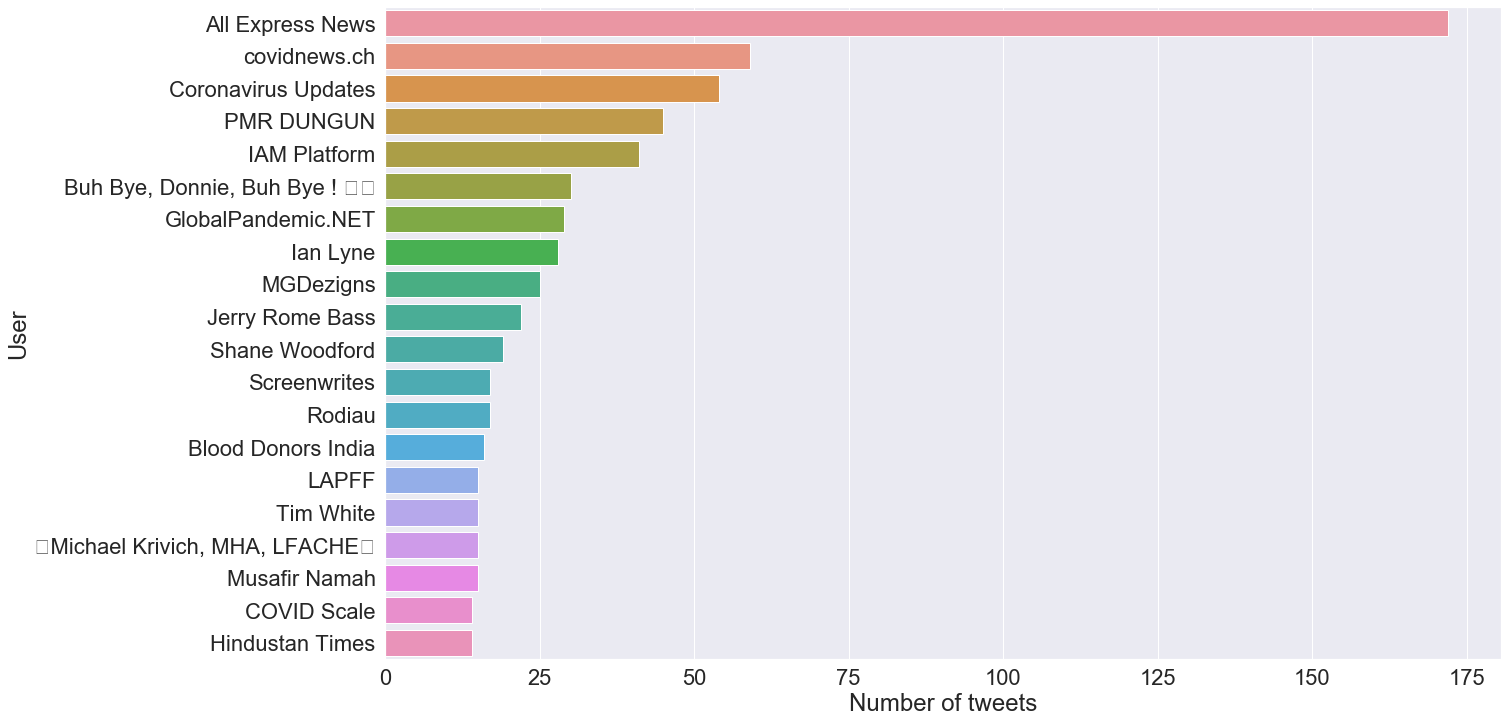

In [60]:
tweet_amount_series = df.user_name.value_counts().reset_index()
tweet_amount_series.columns = ['User', 'Number of tweets']
tweet_amount_series
plt.figure(figsize=(20,12))
sns.barplot(x='Number of tweets', y='User', data=tweet_amount_series.head(20))
sns.set(font_scale=1.5)
plt.show()

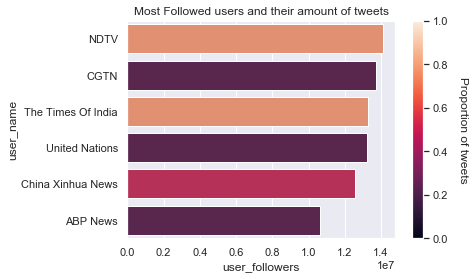

In [103]:
most_followed_series = df.sort_values('user_followers', ascending=False)
most_followed_series.drop_duplicates(subset='user_name')
tweet_amount_series.columns = ['user_name', 'Number of tweets']
most_followed_series = pd.merge(most_followed_series, tweet_amount_series, 'inner')

sns.set(font_scale=1)
normalized = plt.Normalize(most_followed_series['Number of tweets'].min(), most_followed_series['Number of tweets'].max())
scale = plt.cm.ScalarMappable(cmap='rocket')
scale.set_array([])
ax = sns.barplot(x="user_followers", y = "user_name", data = most_followed_series.head(20), hue = 'Number of tweets', dodge = False, palette = 'rocket')
ax.figure.colorbar(scale).set_label('Proportion of tweets', rotation=270, labelpad=20, y=0.5)
ax.legend(loc ='lower center').remove() 
plt.title('Most Followed users and their amount of tweets')
plt.show()

In [ ]:
#Part of day with most traffic

## 4. Tweet Location 

In [120]:
df.user_location.iloc[0]

'Nebraska, USA,'

In [183]:
df['country'] = df.user_location.str.split(',', expand=True)[1].str.strip()

In [184]:
df_loc = df.groupby(['tweet_time', 'location'])['user_name'].count().reset_index()
df_loc.rename(columns={'user_name':'quantity'}, inplace=True)
df_loc

,tweet_time,location,quantity
0,06:09:07,Assam,1
1,06:09:08,India,1
2,06:09:11,Kenya,1
3,06:09:14,WA,1
4,06:09:19,USA,1
...,...,...,...
3848,13:13:13,Kent,1
3849,13:13:15,Québec,1
3850,13:13:15,Suisse,1
3851,13:13:20,Baltimore,1


In [139]:
countries_dict = {}
for country in countries:
    countries_dict[country.name] = country.alpha3

countries_dict

{'Afghanistan': 'AFG',
 'Åland Islands': 'ALA',
 'Albania': 'ALB',
 'Algeria': 'DZA',
 'American Samoa': 'ASM',
 'Andorra': 'AND',
 'Angola': 'AGO',
 'Anguilla': 'AIA',
 'Antarctica': 'ATA',
 'Antigua and Barbuda': 'ATG',
 'Argentina': 'ARG',
 'Armenia': 'ARM',
 'Aruba': 'ABW',
 'Australia': 'AUS',
 'Austria': 'AUT',
 'Azerbaijan': 'AZE',
 'Bahamas': 'BHS',
 'Bahrain': 'BHR',
 'Bangladesh': 'BGD',
 'Barbados': 'BRB',
 'Belarus': 'BLR',
 'Belgium': 'BEL',
 'Belize': 'BLZ',
 'Benin': 'BEN',
 'Bermuda': 'BMU',
 'Bhutan': 'BTN',
 'Bolivia, Plurinational State of': 'BOL',
 'Bonaire, Sint Eustatius and Saba': 'BES',
 'Bosnia and Herzegovina': 'BIH',
 'Botswana': 'BWA',
 'Bouvet Island': 'BVT',
 'Brazil': 'BRA',
 'British Indian Ocean Territory': 'IOT',
 'Brunei Darussalam': 'BRN',
 'Bulgaria': 'BGR',
 'Burkina Faso': 'BFA',
 'Burundi': 'BDI',
 'Cambodia': 'KHM',
 'Cameroon': 'CMR',
 'Canada': 'CAN',
 'Cabo Verde': 'CPV',
 'Cayman Islands': 'CYM',
 'Central African Republic': 'CAF',
 'Chad': 

In [185]:
df_loc['country_code'] = df_loc['location']
df_loc = df_loc.replace({'country_code': countries_dict})

In [186]:
df_loc

,tweet_time,location,quantity,country_code
0,06:09:07,Assam,1,Assam
1,06:09:08,India,1,IND
2,06:09:11,Kenya,1,KEN
3,06:09:14,WA,1,WA
4,06:09:19,USA,1,USA
...,...,...,...,...
3848,13:13:13,Kent,1,Kent
3849,13:13:15,Québec,1,Québec
3850,13:13:15,Suisse,1,Suisse
3851,13:13:20,Baltimore,1,Baltimore


In [190]:
us_list = ['United Kingdom', 'England', 'UK', 'United States']
df_loc = df_loc[(df_loc.country_code == 'USA')|(df_loc['location'].isin(us_list))|(df_loc.location != df_loc.country_code)]
df_loc = df_loc.groupby(['tweet_time', 'location', 'country_code'])['quantity'].sum().reset_index()
df_loc

,tweet_time,location,country_code,quantity
0,06:09:08,India,IND,1
1,06:09:11,Kenya,KEN,1
2,06:09:19,USA,USA,1
3,06:10:09,Canada,CAN,1
4,06:10:36,India,IND,1
...,...,...,...,...
2119,13:12:41,Australia,AUS,1
2120,13:12:43,United Kingdom,GBR,1
2121,13:12:47,Switzerland,CHE,1
2122,13:12:48,United Kingdom,GBR,1


In [191]:
df_loc.quantity.unique()

array([1, 2, 3])

In [192]:
fig = plotex.choropleth(
    df_loc, 
    locations='country_code',
    hover_name='location',
    color='quantity',
    animation_frame='tweet_time',
    projection="natural earth",
    color_continuous_scale=px.colors.sequential.Plasma,
    title='Tweet Location through the day',
    width=800, 
    height=600
)
fig.show()

## 5. LDA Clustering

In [10]:
def clean_tweets(tweet):
    stop_words = set(stopwords.words('english'))
    clean_tweet = re.sub(r'@\w+',' ', tweet)
    clean_tweet = re.sub(r'<.*?>',' ', clean_tweet)
    clean_tweet = re.sub(r'http\S+', ' ', clean_tweet)
    clean_tweet = re.sub(r'\d+',' ', clean_tweet)
    clean_tweet = re.sub(r'#\w+',' ', clean_tweet)
    clean_tweet = tweet.split()
    clean_tweet = " ".join([word for word in clean_tweet if not word in stop_words])
    
    return clean_tweet

In [11]:
df['clean_text'] = df.text.apply(clean_tweets)
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tweet_time,clean_text
0,"Diana ""Sunshine"" Wulf","Nebraska, USA,",SHOW ME WHAT YOU GOT! ☀️🌖✨,2009-05-23 02:16:48,3489,608,29618,False,2020-12-04 13:13:30,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['COVID19'],Twitter Web App,False,13:13:30,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ..."
1,Kanishka,Ranchi,Bicycle Mayor of Ranchi | Author - You & Me | ...,2009-06-27 11:53:29,1583,385,1858,False,2020-12-04 13:13:25,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['CoVID19'],Twitter for Android,False,13:13:25,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ..."
2,Amesh Adalja,"Pittsburgh, Baltimore, NYC",Infectious disease MD (also CCM and EM)working...,2010-12-16 20:41:15,34992,2026,2490,True,2020-12-04 13:13:20,In this piece I’m quoted about the mind-boggli...,NaN,Twitter for iPhone,False,13:13:20,"In piece I’m quoted mind-boggling, insulting, ..."
3,Dimitri Lascaris,"Montréal, Québec","Lawyer, journalist, activist and eco-socialist...",2010-11-12 01:32:04,7765,728,9344,False,2020-12-04 13:13:15,"Over a recent four-week period, the 20 Toronto...",NaN,Twitter for iPhone,False,13:13:15,"Over recent four-week period, 20 Toronto neigh..."
4,sebszczepaniak,"Blonay, Suisse",Cycling enthusiast & Old school football fan.,2011-07-20 15:26:14,127,499,74,False,2020-12-04 13:13:15,A must see #diet #meat #health #COVID19 https:...,"['diet', 'meat', 'health', 'COVID19']",Twitter for iPhone,False,13:13:15,A must see #diet #meat #health #COVID19 https:...


In [13]:
corpus = list(df.clean_text)
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
len(vectorizer.get_feature_names())

39629

In [14]:
lda_tf_chats = LatentDirichletAllocation(n_components=2, random_state=0)
lda_tf_chats.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=2, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [15]:
pyLDAvis.sklearn.prepare(lda_tf_chats, X, vectorizer)

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.043209  0.0       1        1  67.349781
0     -0.043209  0.0       2        1  32.650219, topic_info=               Term       Freq      Total Category  logprob  loglift
18248         india  16.000000  16.000000  Default  30.0000  30.0000
27076            pm  15.000000  15.000000  Default  29.0000  29.0000
34990         trump  29.000000  29.000000  Default  28.0000  28.0000
37904         women   9.000000   9.000000  Default  27.0000  27.0000
24050  narendramodi  10.000000  10.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
37996         world   9.138717  25.386089   Topic2  -7.3050   0.0976
36365       vaccine  11.886496  78.291786   Topic2  -7.0421  -0.7657
27312      positive   8.043815  25.574989   Topic2  -7.4326  -0.0374
34036           the   8.978173  68.511533   Topic2  -7.3228  -0.9129
16659        health   7.978687  37.919566   Topic2  -7.4408  -0.4394

[162 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
0          2  0.946536           00
265        1  0.987111          100
495        2  0.987370       16days
563        1  0.628916           19
563        2  0.373419           19
...      ...       ...          ...
38324      1  0.965684  xboxseriesx
38776      1  0.925085         year
38776      2  0.040221         year
38939      1  0.986398          you
38939      2  0.031819          you

[181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## 6. Sentiment Analysis

In [7]:
def result(annotations):
    score = annotations.document_sentiment.score
    magnitude = annotations.document_sentiment.magnitude
    for index, sentence in enumerate(annotations.sentences):
        sentence_sentiment = sentence.sentiment.score
    return score

In [8]:
def get_sentiment(content):
    client = language.LanguageServiceClient()
    document = types.Document(
                content=content,
                type=enums.Document.Type.PLAIN_TEXT,
                language='en')
    annotations = client.analyze_sentiment(document=document)
    return result(annotations)

In [12]:
sentiment = []
for text in tqdm(df.clean_text):
    sentiment.append(get_sentiment(text))
    time.sleep(.300)
df["sentiment"] = sentiment

100%|██████████| 10000/10000 [1:02:11<00:00,  2.68it/s]


In [13]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,tweet_time,clean_text,sentiment
0,"Diana ""Sunshine"" Wulf","Nebraska, USA,",SHOW ME WHAT YOU GOT! ☀️🌖✨,2009-05-23 02:16:48,3489,608,29618,False,2020-12-04 13:13:30,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['COVID19'],Twitter Web App,False,13:13:30,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",0.0
1,Kanishka,Ranchi,Bicycle Mayor of Ranchi | Author - You & Me | ...,2009-06-27 11:53:29,1583,385,1858,False,2020-12-04 13:13:25,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",['CoVID19'],Twitter for Android,False,13:13:25,"@PrisonPlanet Low-Level ""Marijuana Offenders"" ...",0.0
2,Amesh Adalja,"Pittsburgh, Baltimore, NYC",Infectious disease MD (also CCM and EM)working...,2010-12-16 20:41:15,34992,2026,2490,True,2020-12-04 13:13:20,In this piece I’m quoted about the mind-boggli...,NaN,Twitter for iPhone,False,13:13:20,"In piece I’m quoted mind-boggling, insulting, ...",-0.7
3,Dimitri Lascaris,"Montréal, Québec","Lawyer, journalist, activist and eco-socialist...",2010-11-12 01:32:04,7765,728,9344,False,2020-12-04 13:13:15,"Over a recent four-week period, the 20 Toronto...",NaN,Twitter for iPhone,False,13:13:15,"Over recent four-week period, 20 Toronto neigh...",0.0
4,sebszczepaniak,"Blonay, Suisse",Cycling enthusiast & Old school football fan.,2011-07-20 15:26:14,127,499,74,False,2020-12-04 13:13:15,A must see #diet #meat #health #COVID19 https:...,"['diet', 'meat', 'health', 'COVID19']",Twitter for iPhone,False,13:13:15,A must see #diet #meat #health #COVID19 https:...,0.9


In [14]:
df.to_csv('covid_tweets_sentiments.csv')

In [ ]:
df = pd.read_csv('covid_tweets_sentiments.csv', index_col=0)

In [17]:
df_pos = df.loc[df.sentiment >= 0.0]
df_pos.shape[0]

6810

In [18]:
df_neg = df.loc[df.sentiment < 0.0]
df_neg.shape[0]

3190

In [34]:
positive_texts = df_pos.clean_text
negative_texts = df_neg.clean_text

In [35]:
positive_texts

0       @PrisonPlanet Low-Level "Marijuana Offenders" ...
1       @PrisonPlanet Low-Level "Marijuana Offenders" ...
3       Over recent four-week period, 20 Toronto neigh...
4       A must see #diet #meat #health #COVID19 https:...
5       Sharing Ottawa’s Daily #COVID19 Testing Update...
                              ...                        
9995    6 days #UHCDay #Bain @Alfajiri asking: Are lea...
9996    @black_to_fade @Psydonix @AnonDCC Check Father...
9997    #CoronaVirusUpdates: #COVID19 India Tracker (A...
9998    @NeilClark66 @ClarkeMicah EXPLOSIVE! Dr. Sucha...
9999    India’s active Caseload dips 4.35% Total Cases...
Name: clean_text, Length: 6810, dtype: object

In [57]:
def remove_punctuation(txt):
    """
    """

    return " ".join(re.sub(r'([^0-9A-Za-z \t])|(\w+:\/\/\S+)', '', txt).split())

In [58]:
def clean_text(texto):
    stop_words = set(stopwords.words('english'))
    tmp = [remove_punctuation(t) for t in texto]
    tmp = [t.lower().split() for t in tmp]
    
    tmp = [[w for w in t if not w in stop_words]
              for t in tmp]
    
    tmp = list(itertools.chain(*tmp))
    tmp = collections.Counter(tmp)
        
    return tmp

In [59]:
clean_positive_texts = clean_text(positive_texts)
clean_negative_texts = clean_text(negative_texts)

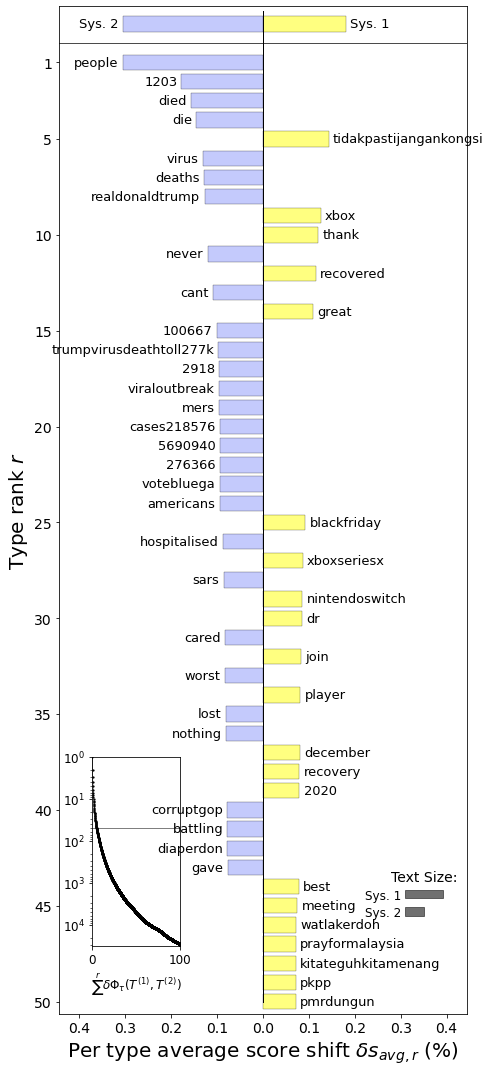

In [60]:
jsd_shift = ss.JSDivergenceShift(system_1=clean_positive_texts,
                                 system_2=clean_negative_texts,
                                 base=2)
                                 
jsd_shift.get_shift_graph()